In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week2_model_based/submit.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week2_model_based/mdp.py

    !touch .setup_complete

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'


In [ ]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

In [ ]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


In [ ]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


In [ ]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


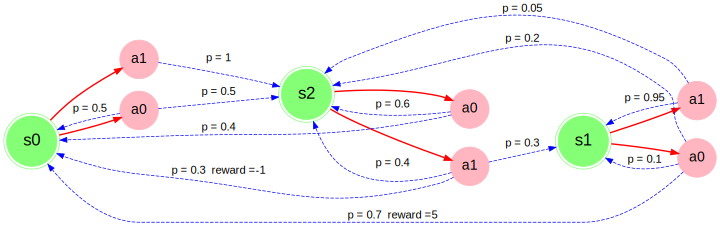

In [ ]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

In [ ]:
%%writefile mdp_get_action_value.py

def get_action_value(mdp, state_values, state, action, gamma):
    Q = 0
    for s_prime in mdp.get_all_states():  

        P = mdp.get_transition_prob(state,action,s_prime)
        r = mdp.get_reward(state,action,s_prime)
        Q = Q + P*(r + gamma*state_values[s_prime])

    return Q

Overwriting mdp_get_action_value.py


In [ ]:
import importlib

import mdp_get_action_value
importlib.reload(mdp_get_action_value)

from mdp_get_action_value import get_action_value


In [ ]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

In [ ]:
def get_new_state_value(mdp, state_values, state, gamma):
    if mdp.is_terminal(state):
        return 0
    V_ip1 = max(get_action_value(mdp,state_values,state,action,gamma) for action in mdp.get_possible_actions(state))
    
    return V_ip1

In [ ]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

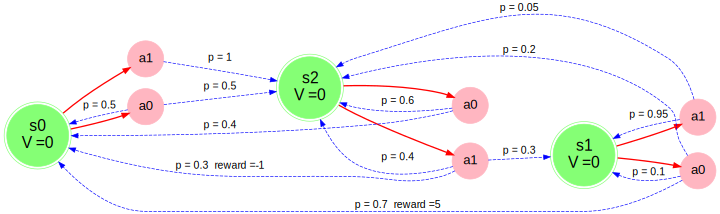

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [ ]:
gamma = 0.9      
num_iter = 100     
min_difference = 0.001
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    new_state_values = {s: get_new_state_value(mdp,state_values,s,gamma) for s in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

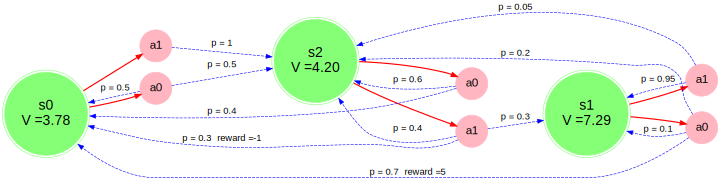

In [ ]:
if has_graphviz:
  display(plot_graph_with_state_values(mdp,state_values))

In [ ]:
print("final state values:",state_values )
assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01 


final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


In [ ]:
import random

def get_optimal_action(mdp, state_values, state, gamma=0.9):
    if mdp.is_terminal(state):
        return None
    Q_dict = {action: get_action_value(mdp,state_values,state,action,gamma) for action in mdp.get_possible_actions(state)}

    max_Q = max(Q_dict.values())
    max_actions = [action for action, Q in Q_dict.items() if Q == max_Q]
    
    return random.choice(max_actions)



In [ ]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0'
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1'
  



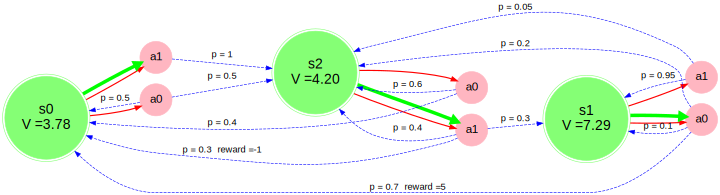

In [ ]:
if has_graphviz:
  try:
    display(plot_graph_optimal_strategy_and_state_values(mdp,state_values,get_action_value))
  except ImportError:
    raise ImportError("Run the cell that starts with \"%%writefile mdp_get_action_value.py\"")

In [ ]:
s = mdp.reset()
rewards = []
for _ in range(10000):
  s,r,done,_ = mdp.step(get_optimal_action(mdp,state_values,s,gamma))
  rewards.append(r)
print("average rewards: ",np.mean(rewards))
assert (0.40 < np.mean(rewards) <0.55)
  

average rewards:  0.4704


In [ ]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance = 0)
mdp.render()

*FFF
FHFH
FFFH
HFFG



In [ ]:
def value_iteration(mdp,state_values = None,gamma = 0.9,num_iter = 1000,min_difference = 1e-5):
  state_values = state_values or {s : 0 for s in mdp.get_all_states()}
  for i in range(num_iter):
    new_state_values = {s : get_new_state_value(mdp,state_values,s,gamma) for s in mdp.get_all_states()}
    assert isinstance(new_state_values,dict)
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("iter %4i | diff %6.5f |  V(start): %.3f " % (i,diff,new_state_values[mdp._initial_state]))
    state_values = new_state_values
    if diff < min_difference:
      break 
  return state_values 


In [ ]:
state_values = value_iteration(mdp)

iter    0 | diff 1.00000 |  V(start): 0.000 
iter    1 | diff 0.90000 |  V(start): 0.000 
iter    2 | diff 0.81000 |  V(start): 0.000 
iter    3 | diff 0.72900 |  V(start): 0.000 
iter    4 | diff 0.65610 |  V(start): 0.000 
iter    5 | diff 0.59049 |  V(start): 0.590 
iter    6 | diff 0.00000 |  V(start): 0.590 


In [ ]:
s = mdp.reset()
mdp.render()
for t in range(100):
  a = get_optimal_action(mdp,state_values,s,gamma)
  print(a)
  s,r,done,_ = mdp.step(a)
  mdp.render()
  if done:
    break  

*FFF
FHFH
FFFH
HFFG

down
SFFF
*HFH
FFFH
HFFG

down
SFFF
FHFH
*FFH
HFFG

right
SFFF
FHFH
F*FH
HFFG

down
SFFF
FHFH
FFFH
H*FG

right
SFFF
FHFH
FFFH
HF*G

right
SFFF
FHFH
FFFH
HFF*



In [ ]:
import matplotlib.pyplot as plt
def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()


after iteration:0
iter    0 | diff 1.00000 |  V(start): 0.000 


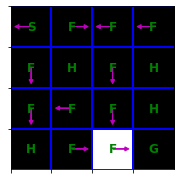

after iteration:1
iter    0 | diff 0.90000 |  V(start): 0.000 


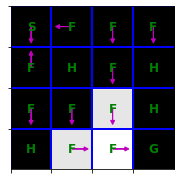

after iteration:2
iter    0 | diff 0.81000 |  V(start): 0.000 


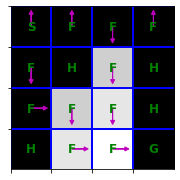

after iteration:3
iter    0 | diff 0.72900 |  V(start): 0.000 


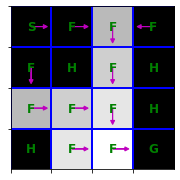

after iteration:4
iter    0 | diff 0.65610 |  V(start): 0.000 


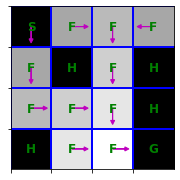

after iteration:5
iter    0 | diff 0.59049 |  V(start): 0.590 


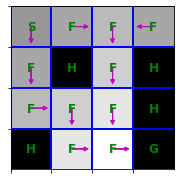

after iteration:6
iter    0 | diff 0.00000 |  V(start): 0.590 


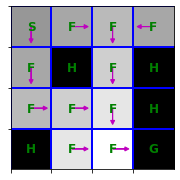

after iteration:7
iter    0 | diff 0.00000 |  V(start): 0.590 


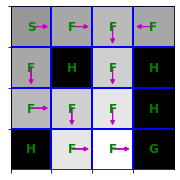

after iteration:8
iter    0 | diff 0.00000 |  V(start): 0.590 


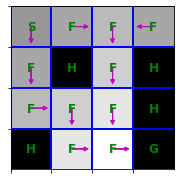

after iteration:9
iter    0 | diff 0.00000 |  V(start): 0.590 


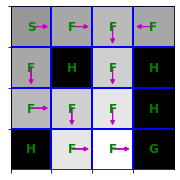

In [ ]:
state_values = {s : 0 for s in mdp.get_all_states()}
for i in range(10):
  print("after iteration:%i" %i)
  state_values = value_iteration(mdp,state_values,num_iter = 1)
  draw_policy(mdp,state_values)


after iteration 29
iter    0 | diff 0.00000 |  V(start): 0.198 


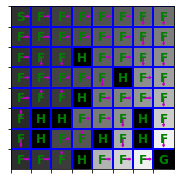

In [ ]:
from IPython.display import clear_output
from time import sleep 
mdp = FrozenLakeEnv(map_name = '8x8', slip_chance = 0.1)
state_values = {s: 0 for s in mdp.get_all_states()}
for i in range(30):
  clear_output(True)
  print("after iteration %i" %i)
  state_values = value_iteration(mdp,state_values,num_iter =1)
  draw_policy(mdp,state_values)
  sleep(0.5)



In [ ]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)
total_rewards = []
for game_i in range(1000):
  s = mdp.reset()
  rewards = []
  for t in range(100):
    s,r,done,_ = mdp.step(get_optimal_action(mdp,state_values,s,gamma))
    rewards.append(r)
    if done:
      break 
  total_rewards.append(np.sum(rewards))
print("average rewards: ",np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("cool")        

iter    0 | diff 1.00000 |  V(start): 0.000 
iter    1 | diff 0.90000 |  V(start): 0.000 
iter    2 | diff 0.81000 |  V(start): 0.000 
iter    3 | diff 0.72900 |  V(start): 0.000 
iter    4 | diff 0.65610 |  V(start): 0.000 
iter    5 | diff 0.59049 |  V(start): 0.590 
iter    6 | diff 0.00000 |  V(start): 0.590 
average rewards:  1.0
cool


In [ ]:
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)
total_rewards = []
for game_i in range(1000):
  s = mdp.reset()
  rewards = []
  for t in range(100):
    s,r,done,_ = mdp.step(get_optimal_action(mdp,state_values,s,gamma))
    rewards.append(r)
    if done:
      break 
  total_rewards.append(np.sum(rewards))
print("average rewards: ",np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("cool") 

iter    0 | diff 0.90000 |  V(start): 0.000 
iter    1 | diff 0.72900 |  V(start): 0.000 
iter    2 | diff 0.62330 |  V(start): 0.000 
iter    3 | diff 0.50487 |  V(start): 0.000 
iter    4 | diff 0.40894 |  V(start): 0.000 
iter    5 | diff 0.34868 |  V(start): 0.349 
iter    6 | diff 0.06529 |  V(start): 0.410 
iter    7 | diff 0.05832 |  V(start): 0.468 
iter    8 | diff 0.01139 |  V(start): 0.480 
iter    9 | diff 0.00764 |  V(start): 0.487 
iter   10 | diff 0.00164 |  V(start): 0.489 
iter   11 | diff 0.00094 |  V(start): 0.490 
iter   12 | diff 0.00022 |  V(start): 0.490 
iter   13 | diff 0.00011 |  V(start): 0.490 
iter   14 | diff 0.00003 |  V(start): 0.490 
iter   15 | diff 0.00001 |  V(start): 0.490 
iter   16 | diff 0.00000 |  V(start): 0.490 
average rewards:  0.874
cool
